<a href="https://www.kaggle.com/code/matthewweisberg/titanic-knn-svm-rf?scriptVersionId=111100914" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Import Packages and Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import random

random.seed(6278)
sns.set_style('whitegrid') # Set style

# Import dataset into two DataFrames
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

test_key = test['PassengerId']
SEED = 6278

# Clean Data
## Visualize Missing Data

In [3]:
# Count NA in train data
train_na = (train.isna().sum()/len(train)).sort_values(ascending=False).to_frame(name='Train NA')
# Count NA in test data
test_na = (test.isna().sum()/len(train)).to_frame(name='Test NA')
pd.concat([train_na, test_na], axis=1).T

,Cabin,Age,Embarked,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare
Train NA,0.771044,0.198653,0.002245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Test NA,0.367003,0.096521,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.001122


## Analyze Title
The actual name holds little informational value, but the associated title contains more.

Using regex, pull out the title from the Name column and visualize the different counts of title.

As there are many one-off obscure title's, analyze and map them to a simpler title scheme for use by the models.

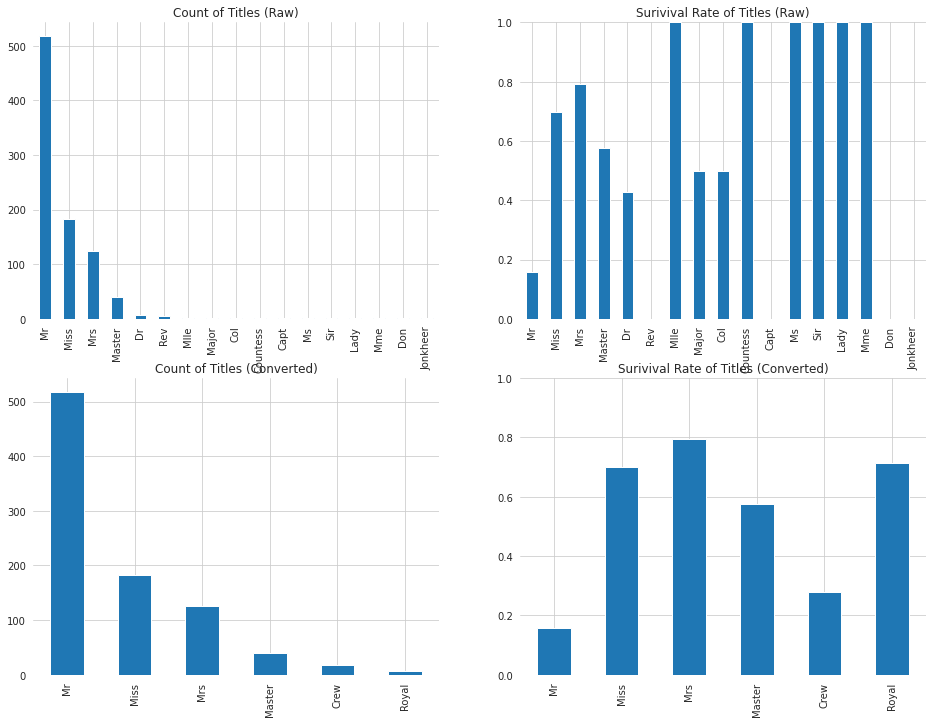

In [4]:
# Extract the title from the Name column
train['Title'] = train['Name'].apply(lambda name: re.findall(',[a-z ]* ([A-Z][a-z]+). |$', name)[0])
test['Title'] = test['Name'].apply(lambda name: re.findall(', ([A-Z][a-z]+). |$', name)[0])

# Create figure for plotting the titles
fig, axs = plt.subplots(2, 2, figsize=[16,12])

# Plot the number of raw titles first extract in a bar plot
train['Title'].value_counts().plot.bar(title='Count of Titles (Raw)', ax=axs[0,0]);
title_order = list(train['Title'].value_counts().index)

train.groupby('Title').mean()['Survived'].reindex(index=title_order).plot.bar(title='Surivival Rate of Titles (Raw)', ax=axs[0,1])

title_map = {'Mr':'Mr',
             'Miss':'Miss', 'Ms':'Miss',
             'Mrs':'Mrs', 'Mme':'Mrs',
             'Master':'Master',
             'Dr':'Crew', 'Rev':'Crew', 'Col':'Crew', 'Capt':'Crew', 'Major':'Crew', 
             'Mlle':'Royal', 'Countess':'Royal', 'Sir':'Royal', 'Lady':'Royal', 'Don':'Royal', 'Jonkheer':'Royal', 'Dona':'Royal'}

train['Title Conv'] = train['Title'].map(title_map)
test['Title Conv'] = test['Title'].map(title_map)

train['Title Conv'].value_counts().plot.bar(title='Count of Titles (Converted)', ax=axs[1,0]);
title_order_conv = list(train['Title Conv'].value_counts().index)

train.groupby('Title Conv').mean()['Survived'].reindex(index=title_order_conv).plot.bar(title='Surivival Rate of Titles (Converted)', ax=axs[1,1])

axs[0,1].set_ylim([0,1])
axs[0,1].set_xlabel('')
axs[1,1].set_ylim([0,1])
axs[1,1].set_xlabel('')

train = train.drop(['Name','Title'], axis=1)
test = test.drop(['Name','Title'], axis=1)

sns.despine(left=True, bottom=True)

# Preprocessing and Visualize Data
## Visualizing Age

Using a violin plots and histogram to understand the impact of age on survival rate.  It seems that the shape distribution is quite different for the two and also that the data does not have a normal distribution.

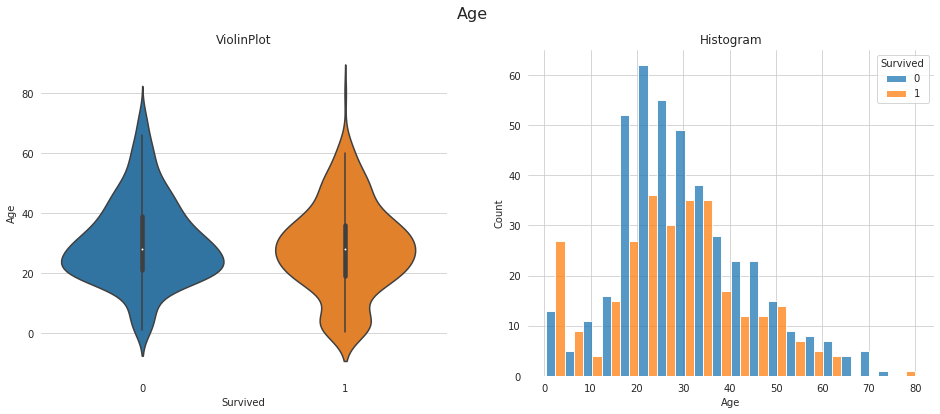

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,6])
fig.suptitle('Age', fontsize=16)

sns.violinplot(data=train, y='Age', x='Survived', ax=ax1) 
sns.histplot(data=train, x='Age', hue="Survived", ax=ax2, multiple="dodge")
sns.despine(left=True, bottom=True)
ax1.set_title('ViolinPlot')
ax2.set_title('Histogram');

ss_age = StandardScaler()
train['Age'] = ss_age.fit_transform(train[['Age']])
test['Age'] = ss_age.transform(test[['Age']])

## Visualizing Sex, Embarked, Pclass
Calculating the rate of survival for each categorical value in the listed features gives a quick view on if they can be used to help determine Survival of the passenger.  It is very clear that all three features have some statistical signficance in the difference between survival rates of their values.

Since each feature has at most 3 distinct values, it will be possible to One-Hot-Encode each for training.

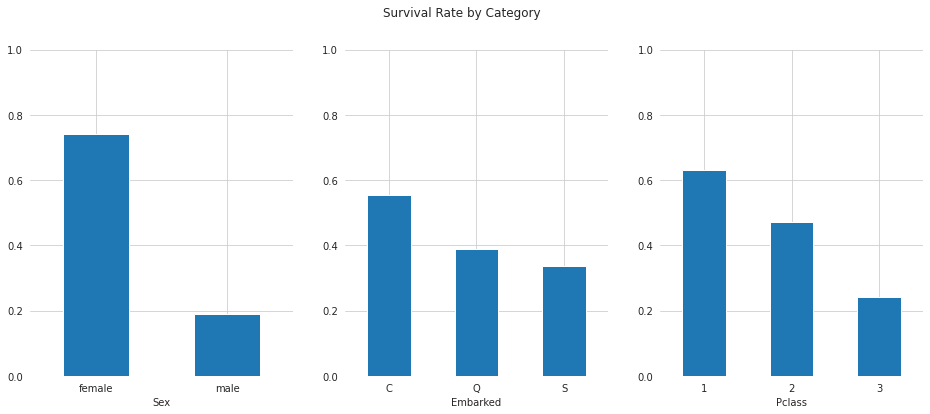

In [6]:
cat_cols = ['Sex','Embarked','Pclass'] # Examine the following three features
fig, axs = plt.subplots(1,3, figsize=[16,6])
fig.suptitle('Survival Rate by Category')

for ax, col in zip(axs, cat_cols): # Loop through a feature and assign it an axis
    train.groupby(col).mean()['Survived'].plot.bar(ax=ax) # Since survived is 1/0 binary, the mean will be the percentage that suvrives
    sns.despine(left=True, bottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    ax.set_ylim([0,1])

train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode())
test['Embarked'] = test['Embarked'].fillna(train['Embarked'].mode())

train['Sex'] = train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
test['Sex'] = test['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train = pd.get_dummies(train, columns=['Embarked','Pclass'])
test = pd.get_dummies(test, columns=['Embarked','Pclass'])

Drop Unused Columns

In [7]:
train = train.drop(['Cabin','Ticket','PassengerId'], axis=1)
test = test.drop(['Cabin','Ticket','PassengerId'], axis=1)

## Preprocessing and Visualizing Fare
The values of Fare are extremely non-normal. A simple method to bring the values closer to a standard distribution is to Power Transform it. Although this is not perfect, it does improve the distribution.  It also shows that the more expensive the Fare, the higher the chance of survival.

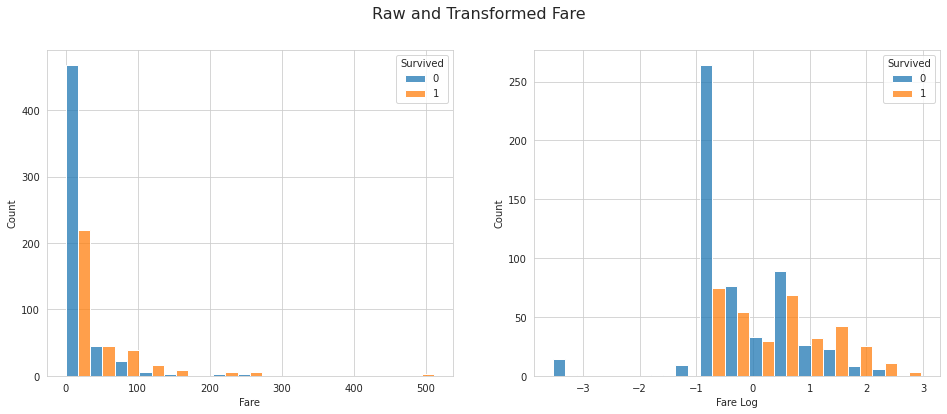

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,6])
fig.suptitle('Raw and Transformed Fare', fontsize = 16)

# Create a PowerTransformer, make sure this is saved, as the transformation of the test data must use the same transformer
pt_fare = PowerTransformer(standardize=True)

train['Fare Log'] = pt_fare.fit_transform(train[['Fare']])
sns.histplot(data=train, x='Fare', hue='Survived', multiple='dodge', bins=15, ax=ax1)
sns.histplot(data=train, x='Fare Log', hue='Survived', multiple='dodge', bins=15, ax=ax2);

test['Fare Log'] = pt_fare.transform(test[['Fare']])
test['Fare Log'] = test['Fare Log'].fillna(train['Fare Log'].mean())

train = train.drop('Fare', axis=1)
test = test.drop('Fare', axis=1)

## Encoding Parch and SibSp
Pull out specific information from Parch and SibSp:
* Is the individual alone on the ship?
* Does the individual have a sibling on the ship?
* Does the individual have a Parent or Child on the ship?

In [9]:
train['NumFam'] = train['Parch'] + train['SibSp']
train['Alone'] = train['NumFam'].apply(lambda x: int(x == 0))
train['HasSib'] = train['SibSp'].apply(lambda x: int(x >= 1))
train['HasPC'] = train['Parch'].apply(lambda x: int(x >= 1))

test['NumFam'] = test['Parch'] + test['SibSp']
test['Alone'] = test['NumFam'].apply(lambda x: int(x == 0))
test['HasSib'] = test['SibSp'].apply(lambda x: int(x >= 1))
test['HasPC'] = test['Parch'].apply(lambda x: int(x >= 1))

train = train.drop(['Parch','SibSp','NumFam'], axis=1)
test = test.drop(['Parch','SibSp','NumFam'], axis=1)

### Revisualize Missing Data

In [10]:
# Count NA in train data
train_na = (train.isna().sum()/len(train)).sort_values(ascending=False).to_frame(name='Train NA')
# Count NA in test data
test_na = (test.isna().sum()/len(train)).to_frame(name='Test NA')
pd.concat([train_na, test_na], axis=1)

,Train NA,Test NA
Age,0.198653,0.096521
Survived,0.000000,NaN
Sex,0.000000,0.000000
Title Conv,0.000000,0.000000
Embarked_C,0.000000,0.000000
Embarked_Q,0.000000,0.000000
Embarked_S,0.000000,0.000000
Pclass_1,0.000000,0.000000
Pclass_2,0.000000,0.000000
Pclass_3,0.000000,0.000000


# Impute Age Values

Compute the missing ages by calculating the mean after grouping the training data by both converted title and sex.

In [11]:
key = dict(train.groupby(['Sex','Title Conv']).mean()['Age'])
train['Age'] = train.apply(lambda x: key[(x['Sex'], x['Title Conv'])] if np.isnan(x['Age']) else x['Age'], axis=1)
test['Age'] = test.apply(lambda x: key[(x['Sex'], x['Title Conv'])] if np.isnan(x['Age']) else x['Age'], axis=1)

train.groupby(['Sex','Title Conv']).agg(['count','mean'])['Age']

train = pd.get_dummies(train, columns=['Title Conv'])
test = pd.get_dummies(test, columns=['Title Conv'])

train = train.drop(['Embarked_S','Pclass_3'],axis=1)
test = test.drop(['Embarked_S','Pclass_3'],axis=1)

# Build and Train Models


In [12]:
# Split the training data into X and y data
X = train.drop('Survived', axis=1)
y = train['Survived']

ss_final = StandardScaler()
X = ss_final.fit_transform(X)
test = ss_final.transform(test)

kf = StratifiedKFold(n_splits=5)

## KNN Classifier

In [13]:
knn = KNeighborsClassifier()
params_knn = [{'n_neighbors':list(range(1,64)), 'weights':['uniform']},
              {'n_neighbors':list(range(1,64)), 'weights':['distance']}]
                              
gs_knn = GridSearchCV(knn, param_grid = params_knn, cv=kf, scoring='accuracy', verbose = 1, n_jobs=-1)
                              
gs_knn.fit(X, y)

rf_knn = pd.DataFrame(gs_knn.cv_results_) # Save results into DataFrame

Fitting 5 folds for each of 126 candidates, totalling 630 fits


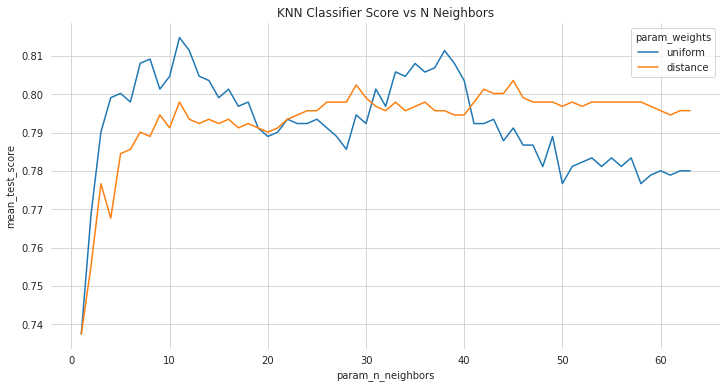

In [14]:
fig = plt.figure(figsize=[12,6])
sns.lineplot(data=rf_knn, x='param_n_neighbors', y='mean_test_score', hue='param_weights')
fig.gca().set_title('KNN Classifier Score vs N Neighbors')
sns.despine(left=True, bottom=True);

## SVM Classifier

In [15]:
svc = SVC(random_state = SEED)

r = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

params_svm=[{'C':r, 'kernel':['linear']},
            {'C':r, 'gamma':r, 'kernel':['rbf']}]

gs_svm = GridSearchCV(estimator=svc, param_grid=params_svm, scoring='accuracy', cv=kf, verbose=1, n_jobs=-1)

gs_svm.fit(X,y)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(random_state=6278), n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['linear']},
                         {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf']}],
             scoring='accuracy', verbose=1)

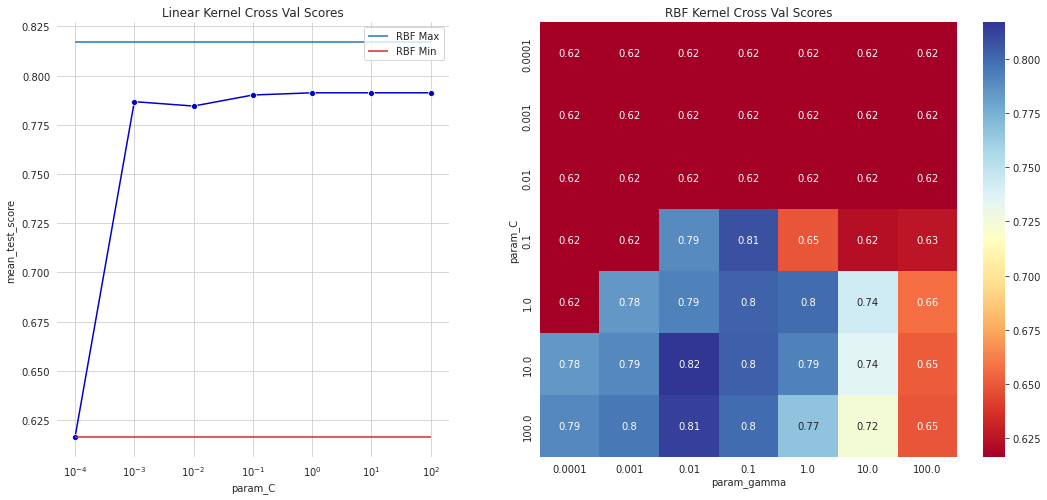

In [16]:
svm_df = pd.DataFrame(gs_svm.cv_results_)
svm_lin_df = svm_df[svm_df['param_kernel'] == 'linear'][['param_C','mean_test_score']]
svm_rbf_df = svm_df[svm_df['param_kernel'] == 'rbf'].pivot(index='param_C', columns='param_gamma', values='mean_test_score')
rbf_max, rbf_min = svm_rbf_df.to_numpy().max(), svm_rbf_df.to_numpy().min()

fig, axs = plt.subplots(1, 2, figsize=[18,8], gridspec_kw={'width_ratios':[3,4]})
sns.lineplot(data=svm_lin_df, x='param_C', y='mean_test_score', marker='o', ax=axs[0], color='mediumblue')
axs[0].set_xscale('log')
axs[0].set_title('Linear Kernel Cross Val Scores');
axs[0].hlines(rbf_max, min(r), max(r), colors=['tab:blue'], label='RBF Max')
axs[0].hlines(rbf_min, min(r), max(r), colors=['tab:red'], label = 'RBF Min')
axs[0].legend()
sns.heatmap(data=svm_rbf_df, cmap = 'RdYlBu', annot=True, ax=axs[1])
axs[1].set_title('RBF Kernel Cross Val Scores')

sns.despine(left=True, bottom=True)

## Random Forest Classifier

In [17]:
rfc = RandomForestClassifier(max_features = 'auto', random_state = SEED) # Random Forest Classifier with default parameters

# Parameter Distribution for randomized search CV
params_rf = {'n_estimators':[10, 100, 400],
            'max_depth': [2, 3, 4, 5, 6, 7],
            'min_samples_split': [2, 16, 32, 64, 128]}

# Initialize GridSearch
gs_rf = GridSearchCV(rfc, param_grid = params_rf, cv=kf, scoring='accuracy', verbose = 1, n_jobs=-1)

gs_rf.fit(X, y)

results = gs_rf.cv_results_
rf_df = pd.DataFrame(results) # Save results into DataFrame

Fitting 5 folds for each of 90 candidates, totalling 450 fits


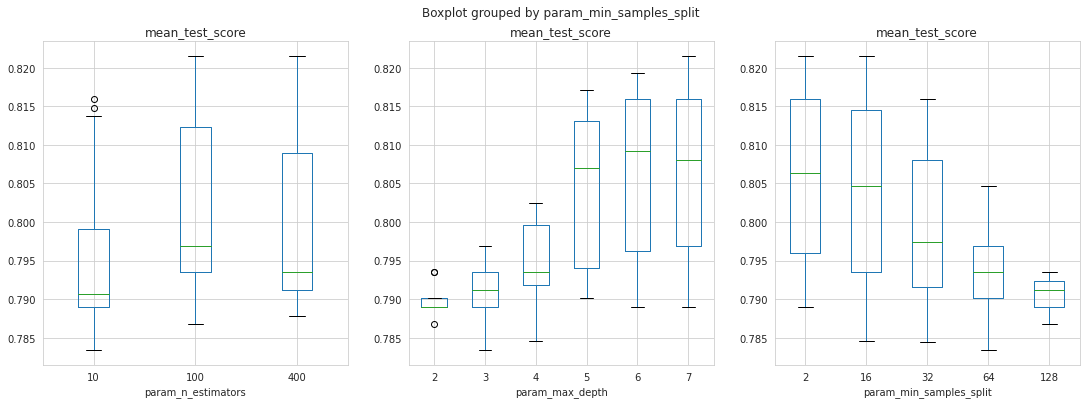

In [18]:
fig, axs = plt.subplots(1, 3, figsize=[18, 6])

for i, param in enumerate(params_rf.keys()):
    rf_df.boxplot(column='mean_test_score', by='param_'+param, ax=axs[i])

# Predict Test Data
Finally!!! Use the best estimator from each grid search cv to predict the labels for the test data. Then ensemble the three models together to determine if you should predict the individual survived. (If mean is > 0.5, then survived)

In [19]:
# Use the best estimator from the GridSearch
model_name = ['SVM', 'RF', 'KNN']
models = [gs_svm.best_estimator_, gs_rf.best_estimator_, gs_knn.best_estimator_]
y_pred_df = pd.DataFrame(test_key)

for name, model in zip(model_name, models):
    model.fit(X, y)
    y_pred = model.predict(test)
    y_pred_df[name] = y_pred

y_pred_df['Cumulative'] = y_pred_df[['SVM','RF','KNN']].mean(axis=1)
y_pred_df['Survived'] = y_pred_df['Cumulative'].apply(lambda x: int(x > 0.5))

In [20]:
submission_Ensemble = y_pred_df[['PassengerId','Survived']]
submission_Ensemble.to_csv('submission.csv',index=False)

submission_svm = y_pred_df[['PassengerId','SVM']]
submission_svm.columns = [['PassengerId','Survived']]
submission_svm.to_csv('SVM.csv',index=False)

submission_rf = y_pred_df[['PassengerId','RF']]
submission_rf.columns = [['PassengerId','Survived']]
submission_rf.to_csv('RF.csv',index=False)

submission_knn = y_pred_df[['PassengerId','KNN']]
submission_knn.columns = [['PassengerId','Survived']]
submission_knn.to_csv('KNN.csv',index=False)